In [1]:
!pip install bertopic -q 
!pip install sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np 
import pandas as pd 
import sys
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfVectorizer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/produce/producersdirectdata.parquet


In [3]:
file_path = "/kaggle/input/produce/producersdirectdata.parquet"

df = pd.read_parquet(file_path)

# Combine both language conditions using the logical AND operator (&)
both_eng_mask = (df['response_language'].str.contains('eng', case=False, na=False)) & \
                (df['question_language'].str.contains('eng', case=False, na=False))

# Apply the combined mask to filter the DataFrame. Using .copy() to avoid SettingWithCopyWarning.
df1 = df[both_eng_mask].copy()

# Select the required columns for analysis
CHALLENGE_4_COLUMNS = [
    'question_id',
    'question_topic',
    'question_content',
    'response_content',
    'question_sent',
    'question_user_country_code',
    'question_language',
    'response_language',
]
df1 = df1[CHALLENGE_4_COLUMNS]

# --- B. Data Cleaning and Classification ---

# 1. NaN Handling
# Fill NaN values in the 'question_topic' column with 'General_Topic'
df1['question_topic'].fillna('General_Topic', inplace=True)


# 2. Text Cleaning (Creating 'question_content_cleaned')
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'^[qes][\s\.\-]*', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Create the cleaned content column
df1['question_content_cleaned'] = df1['question_content'].apply(clean_text)
df1['response_content_cleaned'] = df1['response_content'].apply(clean_text)





# 3. Binary Topic Classification
# List of topics considered 'General' or non-specific
GENERAL_TOPICS_LIST = [
    'General_Topic', 'crop', 'plant', 'animal', 'tree', 'livestock',
    'vegetable', 'bird', 'grass', 'market', 'dog', 'cat', 'poultry'
]

# Create the broad_topic column: Correctly use df1['question_topic'] for the operation
df1['broad_topic'] = df1['question_topic'].apply(
    lambda x: 'General' if x in GENERAL_TOPICS_LIST else 'Specific (Crop/Livestock)'
)

df1.to_csv('df1.csv', index = False)

/tmp/ipykernel_47/1244742823.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['question_topic'].fillna('General_Topic', inplace=True)


In [4]:
#df = df1.sample(n=100000, random_state=42)
df = pd.read_csv('/kaggle/working/df1.csv').sample(n=5000000, random_state=42)

In [6]:
# --- Configuration & Parameters ---
GROUPING_COLUMN = 'question_topic'
TEXT_DEMAND_COLUMN = 'question_content_cleaned'
TEXT_SUPPLY_COLUMN = 'response_content_cleaned'
OUTPUT_FILE = 'semantic_weighted_gap_analysis_final.csv'

# Optimization Parameters for TfidfVectorizer
TFIDF_NGRAM_RANGE = (1, 3) # Optimized for speed
TFIDF_MIN_DF = 1 

# Weighted Scoring Parameters
WEIGHT_SEMANTIC = 0.7  # Weight for specialized depth (TF-IDF)
WEIGHT_COUNT = 0.3     # Weight for foundational coverage (Word Count)


# --- 1. Data Validation and Preparation ---
start_time_total = time.time()
print("\n--- 1. Data Validation and Preparation ---")

# Note: DataFrame 'df' is assumed to be pre-loaded.
if 'df' not in locals():
    # Placeholder df creation for demonstration purposes if running as a standalone script
    data = {
        GROUPING_COLUMN: ['Topic A', 'Topic A', 'Topic B', 'Topic B', 'Topic B'],
        TEXT_DEMAND_COLUMN: ['complex requirement a', 'simple question b', 'very hard problem c', 'easy query d', 'medium task e'],
        TEXT_SUPPLY_COLUMN: ['detailed explanation for a', 'brief answer for b', 'extensive solution to c with deep dive', 'quick reply d', 'moderate response e']
    }
    df = pd.DataFrame(data)


# Validate required columns
required_cols = [GROUPING_COLUMN, TEXT_DEMAND_COLUMN, TEXT_SUPPLY_COLUMN]
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Error: Missing one or more required columns: {required_cols}")

# Data Cleaning: Drop NaNs and ensure string type for text processing
df_clean = df.dropna(subset=required_cols).reset_index(drop=True)
df_clean[TEXT_DEMAND_COLUMN] = df_clean[TEXT_DEMAND_COLUMN].astype(str)
df_clean[TEXT_SUPPLY_COLUMN] = df_clean[TEXT_SUPPLY_COLUMN].astype(str)

print(f"Analysis started on {len(df_clean)} cleaned records.")


# --- 2. Feature Engineering (TF-IDF Scoring & Word Count Scoring) ---
print("\n--- 2. Calculating Semantic & Count Scores (Group-wise TF-IDF) ---")
start_time_tfidf = time.time()

# Helper function for length calculation (needed for word count score)
def calculate_length(text):
    if pd.isna(text) or text is None: return 0
    return len(str(text).split())

# a. --- SEMANTIC SCORE (Group-wise TF-IDF: Measures Professional Depth) ---
# ⚠️ Key Change: Define a function to handle TF-IDF calculation within each group ⚠️
def calculate_group_tfidf_scores(group_df, text_column):
    """Calculates TF-IDF scores within a single group (e.g., a topic)."""
    
    # Instantiate and fit TfidfVectorizer specifically on this group's data
    tfidf_vectorizer_group = TfidfVectorizer(
        stop_words='english', 
        ngram_range=TFIDF_NGRAM_RANGE, 
        min_df=TFIDF_MIN_DF
    )
    
    # Compute the TF-IDF matrix
    X = tfidf_vectorizer_group.fit_transform(group_df[text_column])
    
    # Calculate the mean TF-IDF score for each document (row) as the semantic score
    # .A.flatten() converts the sparse matrix result to a 1D array
    return pd.Series(X.mean(axis=1).A.flatten(), index=group_df.index)

# Demand (Q) Semantic Score - Apply to each group
# We use .apply() and then .reset_index() to ensure scores align with the main DataFrame's index
demand_scores = df_clean.groupby(GROUPING_COLUMN).apply(
    lambda group: calculate_group_tfidf_scores(group, TEXT_DEMAND_COLUMN)
)
# Assign results back to the main DataFrame
# .reset_index(level=0, drop=True) removes the extra index level created by groupby
df_clean['Semantic_Demand_Score'] = demand_scores.reset_index(level=0, drop=True)


# Supply (R) Semantic Score - Apply to each group
supply_scores = df_clean.groupby(GROUPING_COLUMN).apply(
    lambda group: calculate_group_tfidf_scores(group, TEXT_SUPPLY_COLUMN)
)
# Assign results back to the main DataFrame
df_clean['Semantic_Supply_Score'] = supply_scores.reset_index(level=0, drop=True)

print(f"Group-wise TF-IDF calculation time: {time.time() - start_time_tfidf:.2f} seconds.")


# b. --- WORD COUNT SCORE (Raw Length: Measures Foundational Coverage) ---

# Calculate raw length for normalization
df_clean['Response_Length'] = df_clean[TEXT_SUPPLY_COLUMN].apply(calculate_length)

# Min-Max Normalization for Word Count Score
min_len = df_clean['Response_Length'].min()
max_len = df_clean['Response_Length'].max()
if max_len == min_len:
    # Set to 0.5 if min=max to avoid division by zero and provide a neutral score
    df_clean['Word_Count_Score'] = 0.5
else:
    df_clean['Word_Count_Score'] = (df_clean['Response_Length'] - min_len) / (max_len - min_len)


# --- 3. Aggregation and Weighted Gap Calculation ---
print("\n--- 3. Aggregating Scores and Calculating Gap ---")
start_time_agg = time.time()

# Group the data by the existing topic column
grouped_analysis = df_clean.groupby(GROUPING_COLUMN).agg(
    Question_Count=(GROUPING_COLUMN, 'size'),
    # Aggregate Average Demand Complexity (pure semantic score)
    Average_Demand_Complexity=('Semantic_Demand_Score', 'mean'),
    # Aggregate both components of Supply
    Avg_Semantic_Supply=('Semantic_Supply_Score', 'mean'),
    Avg_Word_Count_Supply=('Word_Count_Score', 'mean')
).reset_index()

# Calculate the final weighted Supply Detail Score
grouped_analysis['Average_Supply_Detail'] = (
    (grouped_analysis['Avg_Semantic_Supply'] * WEIGHT_SEMANTIC) + 
    (grouped_analysis['Avg_Word_Count_Supply'] * WEIGHT_COUNT)
)

# Calculate the final Knowledge Gap Score: Demand - Weighted Supply
grouped_analysis['Knowledge_Gap_Score'] = (
    grouped_analysis['Average_Demand_Complexity'] - grouped_analysis['Average_Supply_Detail']
)

# Filter out small groups (e.g., less than 5 questions)
grouped_analysis = grouped_analysis[grouped_analysis['Question_Count'] >= 5] 

end_time_agg = time.time()
print(f"Aggregation and Gap Calculation time: {end_time_agg - start_time_agg:.2f} seconds.")


# --- 4. Final Report Generation ---

# Sort by the largest positive gap score first (Highest Unmet Need)
gap_report = grouped_analysis.sort_values(by='Knowledge_Gap_Score', ascending=False)

# Print Final Report (Top 15 gaps)
print(f"\n--- TOTAL SCRIPT RUNTIME: {time.time() - start_time_total:.2f} seconds ---")
print("\nFINAL WEIGHTED KNOWLEDGE GAP ANALYSIS REPORT (Top 15 Gaps):")
print("Note: Average Supply Detail = (70% Semantic Depth) + (30% Foundational Coverage)")

final_gap_cols = [
    GROUPING_COLUMN, 
    'Knowledge_Gap_Score', 
    'Average_Demand_Complexity', 
    'Average_Supply_Detail', 
    'Question_Count'
]
print(gap_report[final_gap_cols].head(15).to_markdown(index=False, numalign="left", stralign="left"))

# Save the final report
gap_report.to_csv(OUTPUT_FILE, index=False)


--- 1. Data Validation and Preparation ---
Analysis started on 4999998 cleaned records.

--- 2. Calculating Semantic & Count Scores (Group-wise TF-IDF) ---


/tmp/ipykernel_47/2362130679.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demand_scores = df_clean.groupby(GROUPING_COLUMN).apply(
/tmp/ipykernel_47/2362130679.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  supply_scores = df_clean.groupby(GROUPING_COLUMN).apply(


Group-wise TF-IDF calculation time: 304.17 seconds.

--- 3. Aggregating Scores and Calculating Gap ---
Aggregation and Gap Calculation time: 0.81 seconds.

--- TOTAL SCRIPT RUNTIME: 324.42 seconds ---

FINAL WEIGHTED KNOWLEDGE GAP ANALYSIS REPORT (Top 15 Gaps):
Note: Average Supply Detail = (70% Semantic Depth) + (30% Foundational Coverage)
| question_topic   | Knowledge_Gap_Score   | Average_Demand_Complexity   | Average_Supply_Detail   | Question_Count   |
|:-----------------|:----------------------|:----------------------------|:------------------------|:-----------------|
| purple-vetch     | 0.0281079             | 0.0531108                   | 0.0250028               | 15               |
| blackberry       | 0.0179136             | 0.0361299                   | 0.0182163               | 18               |
| rye              | 0.00955732            | 0.0266787                   | 0.0171214               | 53               |
| mulberry         | 0.00892756            | 0.0253323   

In [7]:
# --- 1. Data Loading and Preparation ---

DATA_FILE = 'semantic_weighted_gap_analysis_final.csv'

try:
    df_gaps = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: Analysis file '{DATA_FILE}' not found. Please ensure the file is correct.")
    exit()

# Filter the top 15 rows based on the Gap Score (Highest Unmet Demand)
df_top15 = df_gaps.sort_values(by='Knowledge_Gap_Score', ascending=False).head(15)

# Create a sort order list based on the Gap Score for consistent visualization
y_order = df_top15['question_topic'].tolist()

# Calculate Quadrant Reference Lines for the Prioritization Matrix (Chart 3)
gap_mean = df_gaps['Knowledge_Gap_Score'].mean()
volume_mean = np.exp(np.mean(np.log(df_gaps['Question_Count'])))

print(f"Analysis successfully loaded. Generating 3 charts.")


# 1. Filter the top 10 rows based on the Question_Count (Volume)
df_top10_volume = df_gaps.sort_values(by='Question_Count', ascending=False).head(10)

# --- 2. Create the Bar Chart (Matplotlib/Seaborn equivalent) ---

plt.figure(figsize=(10, 6))

# Use Seaborn barplot for visualization
ax = sns.barplot(
    x='Question_Count', 
    y='question_topic', 
    data=df_top10_volume, 
    palette='Blues_d' # Sequential palette
)

# Set Titles and Labels
plt.title('Top 10 Question Topics by Demand Volume', fontsize=14)
plt.xlabel('Demand Volume (Question Count)', fontsize=12)
plt.ylabel('Question Topic', fontsize=12)

# Add data labels
for container in ax.containers:
    labels = [f'{v.get_width():,.0f}' for v in container] # Format as whole numbers
    ax.bar_label(container, labels=labels, padding=3, fontsize=10)

# Ensure labels are not cut off
plt.xlim(ax.get_xlim()[0], ax.get_xlim()[1] * 1.1)
plt.tight_layout()

# Save as PNG
plt.savefig('top_10_question_volume_report.png', dpi=300)
plt.close()


# === CHART 1: GAP RANKING (Bar Chart) ===
# Goal: Visualize the size of the unmet demand (Top Priority Risk List)

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    x='Knowledge_Gap_Score', 
    y='question_topic', 
    data=df_top15, 
    order=y_order,
    palette='Reds_d' # Sequential palette for risk
)

plt.title('1. Knowledge Gap Ranking: Top 15 Unmet Demand Topics', fontsize=14)
plt.xlabel('Knowledge Gap Score (Demand - Supply)', fontsize=12)
plt.ylabel('Question Topic', fontsize=12)

# Add data labels
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{v.get_width():.4f}' for v in container], padding=3)

plt.tight_layout()
plt.savefig('1_gap_ranking_report.png')
plt.close()
print("Chart 1 generated: 1_gap_ranking_report.png")


# === CHART 2: SUPPLY vs. DEMAND COMPARISON (Grouped Bar Chart) ===
# Goal: Diagnose the mismatch by comparing the two scores side-by-side.

# Prepare the data for folding (long format for Seaborn's 'hue')
df_mismatch = df_top15.melt(
    id_vars=['question_topic', 'Knowledge_Gap_Score'],
    value_vars=['Average_Demand_Complexity', 'Average_Supply_Detail'],
    var_name='Score_Type',
    value_name='Score'
)
df_mismatch['Score_Component'] = df_mismatch['Score_Type'].replace({
    'Average_Demand_Complexity': 'Demand (Complexity)',
    'Average_Supply_Detail': 'Supply (Detail)'
})

plt.figure(figsize=(14, 8))
ax2 = sns.barplot(
    x='Score', 
    y='question_topic', 
    hue='Score_Component', 
    data=df_mismatch, 
    order=y_order, # Ensure prioritization order based on Gap Score
    palette=['#1f77b4', '#ff7f0e'] # Blue for Demand, Orange for Supply
)

plt.title('2. Semantic Mismatch: Demand Complexity vs. Supply Detail', fontsize=16)
plt.xlabel('Average Semantic Score (0-1)', fontsize=14)
plt.ylabel('Question Topic', fontsize=14)
plt.legend(title='Score Type', loc='lower right')

# Add Data Labels (Crucial for visualization)
for container in ax2.containers:
    labels = [f'{v.get_width():.4f}' for v in container]
    ax2.bar_label(container, labels=labels, label_type='edge', padding=5, fontsize=9)

ax2.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1] + 0.005) # Adjust X-axis limit
plt.tight_layout()
plt.savefig('2_supply_demand_mismatch_labeled.png')
plt.close()
print("Chart 2 generated: 2_supply_demand_mismatch_labeled.png")


# === CHART 3: VOLUME vs. GAP (Prioritization Matrix) ===
# Goal: Identify high-risk (Y-axis) and high-impact (X-axis) topics.

plt.figure(figsize=(12, 8))

# Scatter plot: x=Volume (log scale), y=Gap Score
sns.scatterplot(
    x='Question_Count', 
    y='Knowledge_Gap_Score', 
    data=df_gaps, 
    size='Question_Count', 
    hue='Knowledge_Gap_Score',
    sizes=(50, 800), 
    palette='viridis',
    alpha=0.6
)

# Add Quadrant Reference Lines
plt.axvline(x=volume_mean, color='gray', linestyle='--', linewidth=1.5, label=f'Avg Volume ({volume_mean:.0f})')
plt.axhline(y=gap_mean, color='red', linestyle='--', linewidth=1.5, label=f'Avg Gap ({gap_mean:.4f})')

# Add Labels (Annotations) for the Top 15 High-Risk Topics
for index, row in df_top15.iterrows():
    plt.annotate(
        row['question_topic'], 
        (row['Question_Count'], row['Knowledge_Gap_Score']),
        textcoords="offset points", 
        xytext=(5, 5), # Offset text slightly from the point
        ha='left', 
        fontsize=9, 
        fontweight='bold',
        color='black'
    )

# Set Axes and Title
plt.xscale('log') 
plt.title('3. Prioritization Matrix: Volume vs. Semantic Gap', fontsize=16)
plt.xlabel('Demand Volume (Question Count - Log Scale)', fontsize=14)
plt.ylabel('Knowledge Gap Score (Unmet Demand)', fontsize=14)
plt.legend(loc='lower left', title='Reference Lines')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.savefig('3_priority_matrix_labeled_seaborn.png')
plt.close()
print("Chart 3 generated: 3_priority_matrix_labeled_seaborn.png")

#print("\nAll 3 visualization files have been generated successfully.")<ctrl46>}

Analysis successfully loaded. Generating 3 charts.
Chart 1 generated: 1_gap_ranking_report.png
Chart 2 generated: 2_supply_demand_mismatch_labeled.png
Chart 3 generated: 3_priority_matrix_labeled_seaborn.png


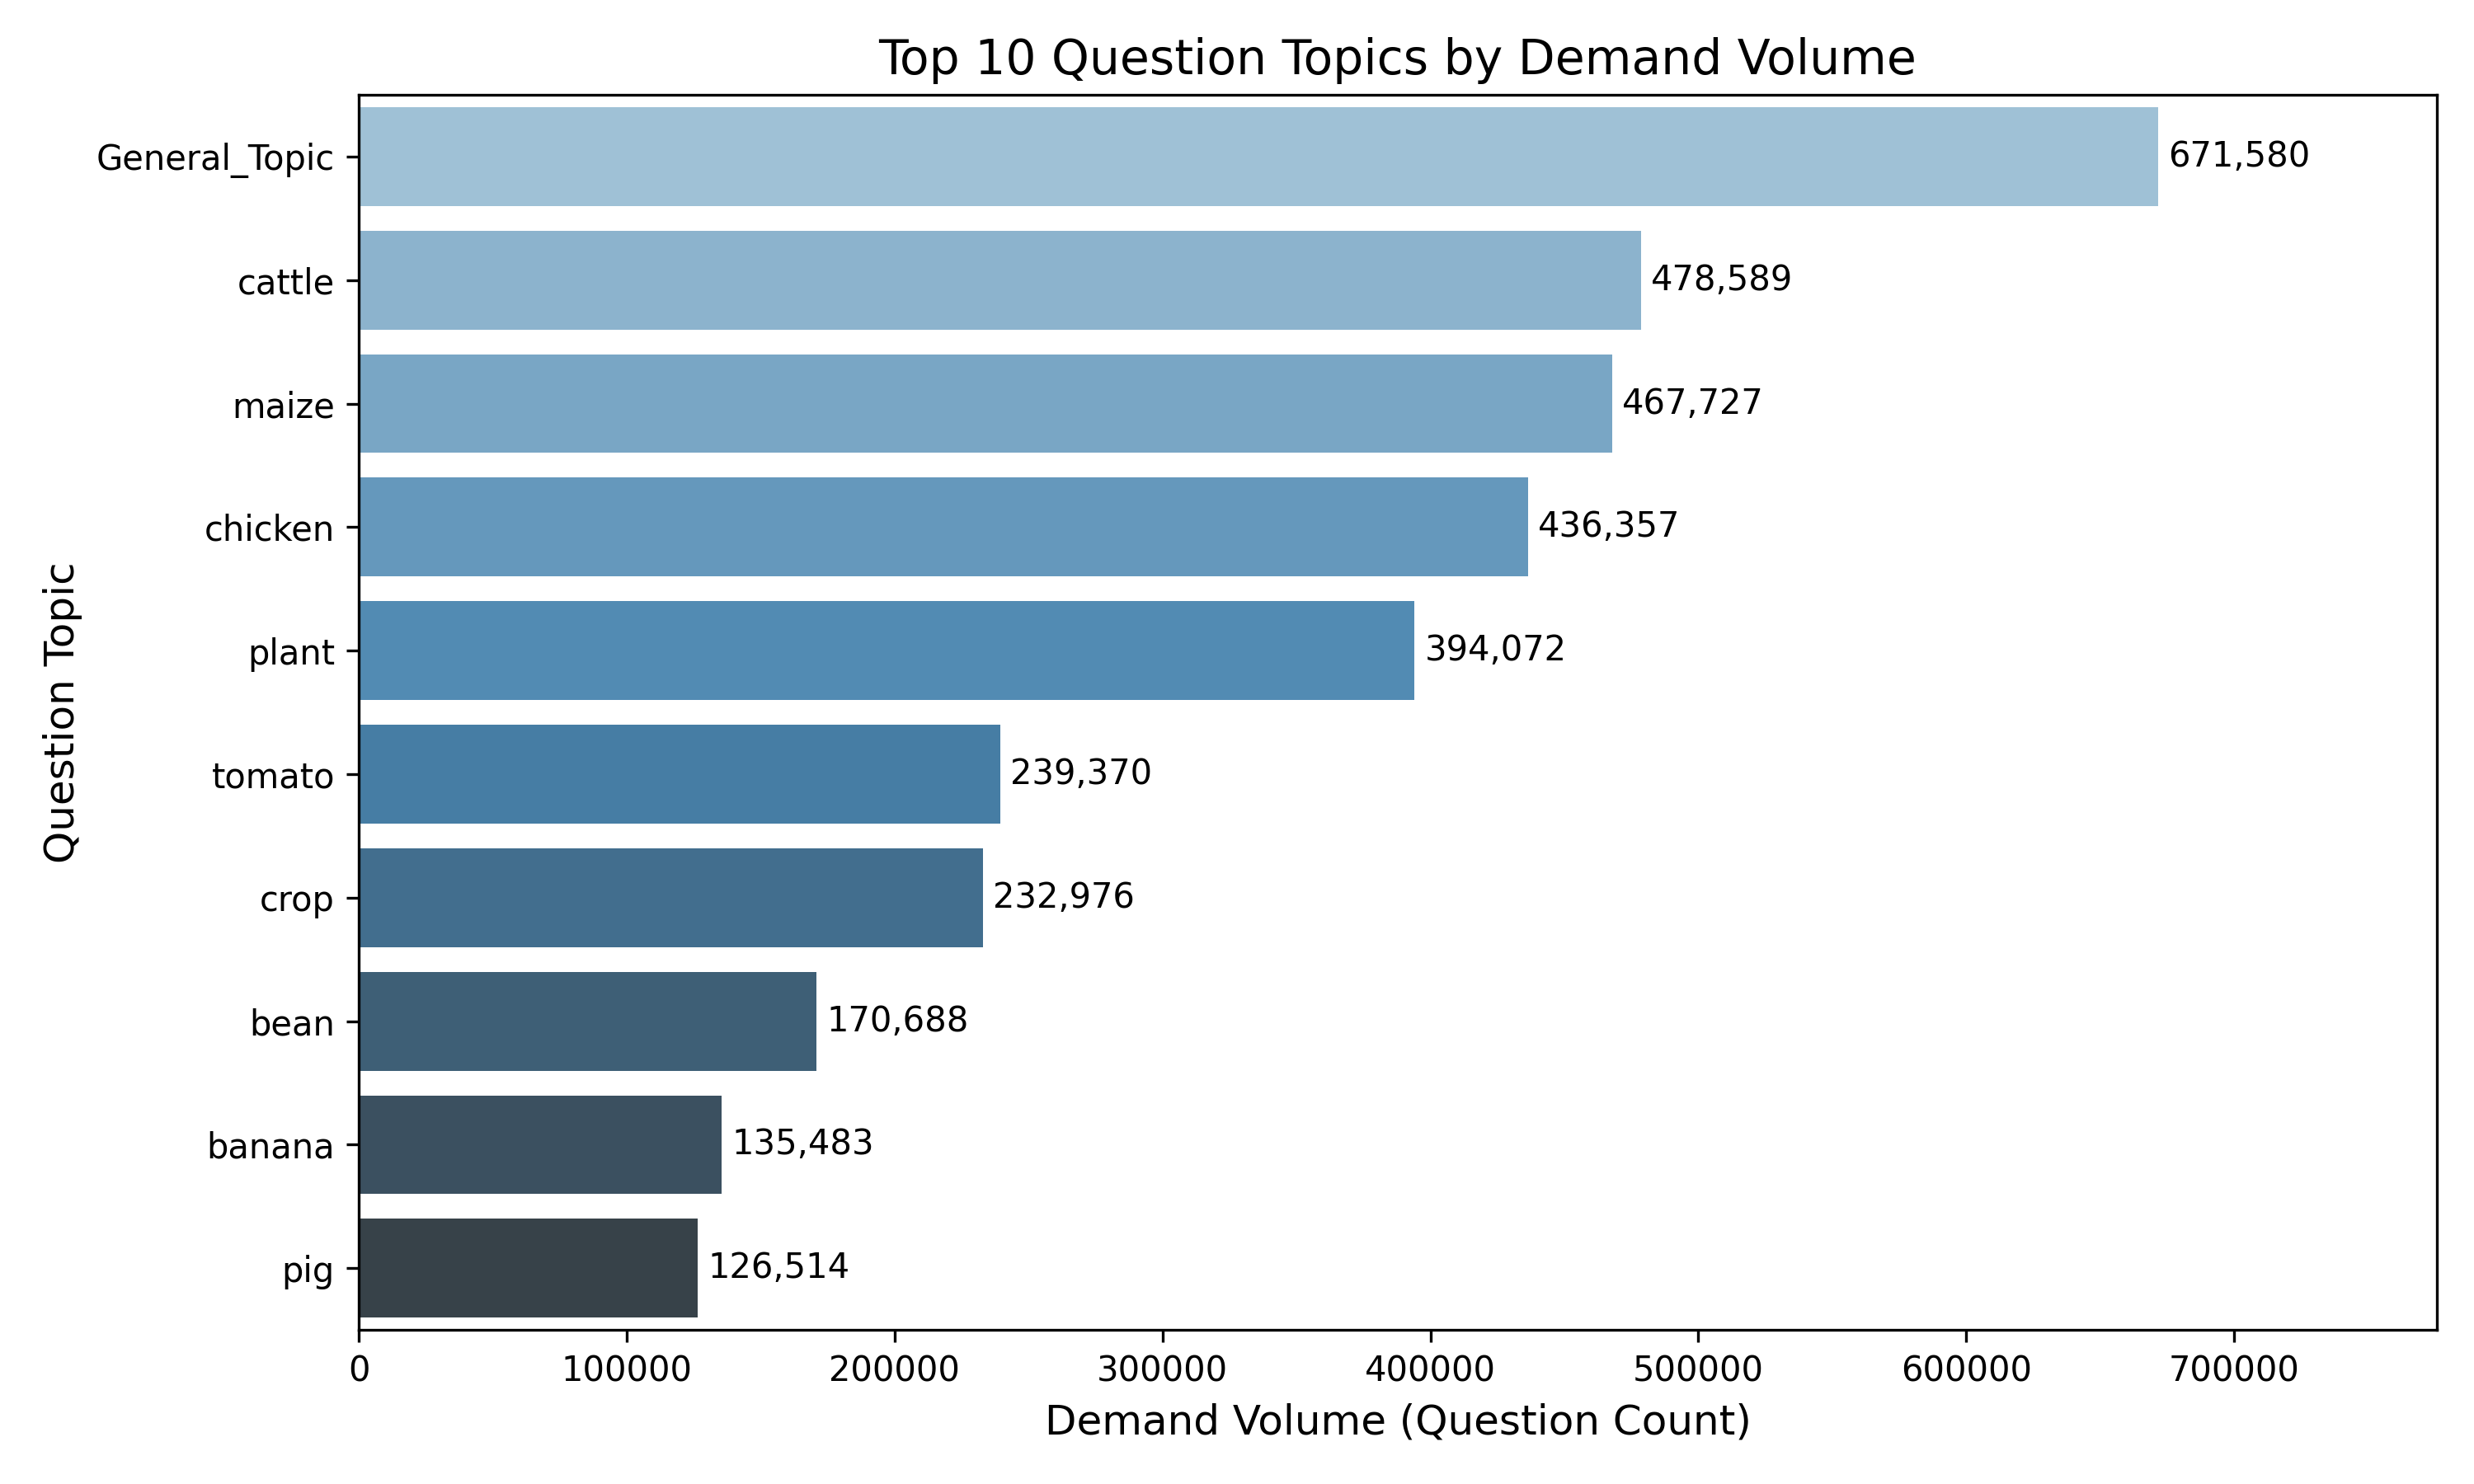

In [8]:
Image('top_10_question_volume_report.png')

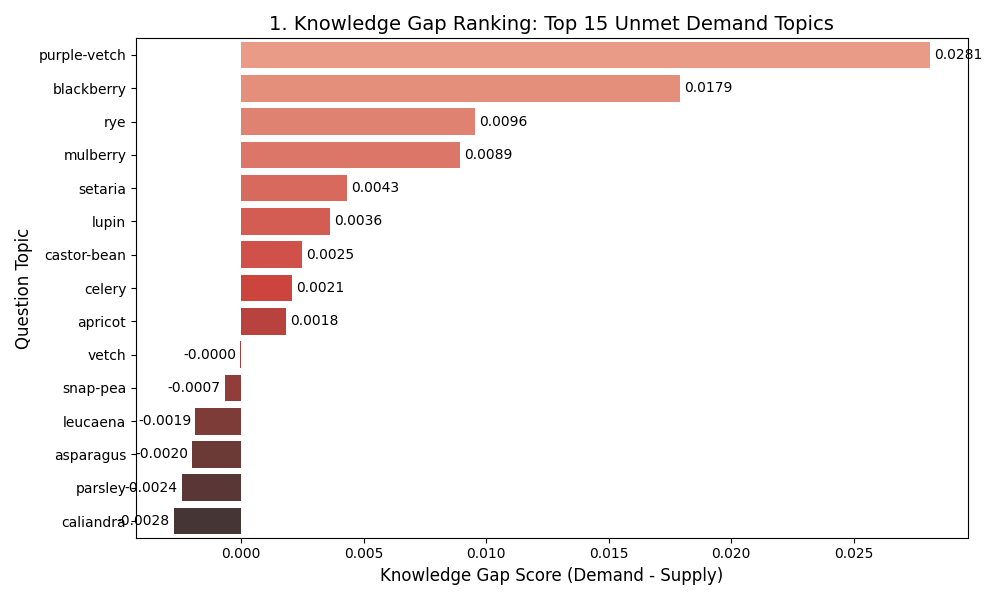

In [10]:
Image('1_gap_ranking_report.png')

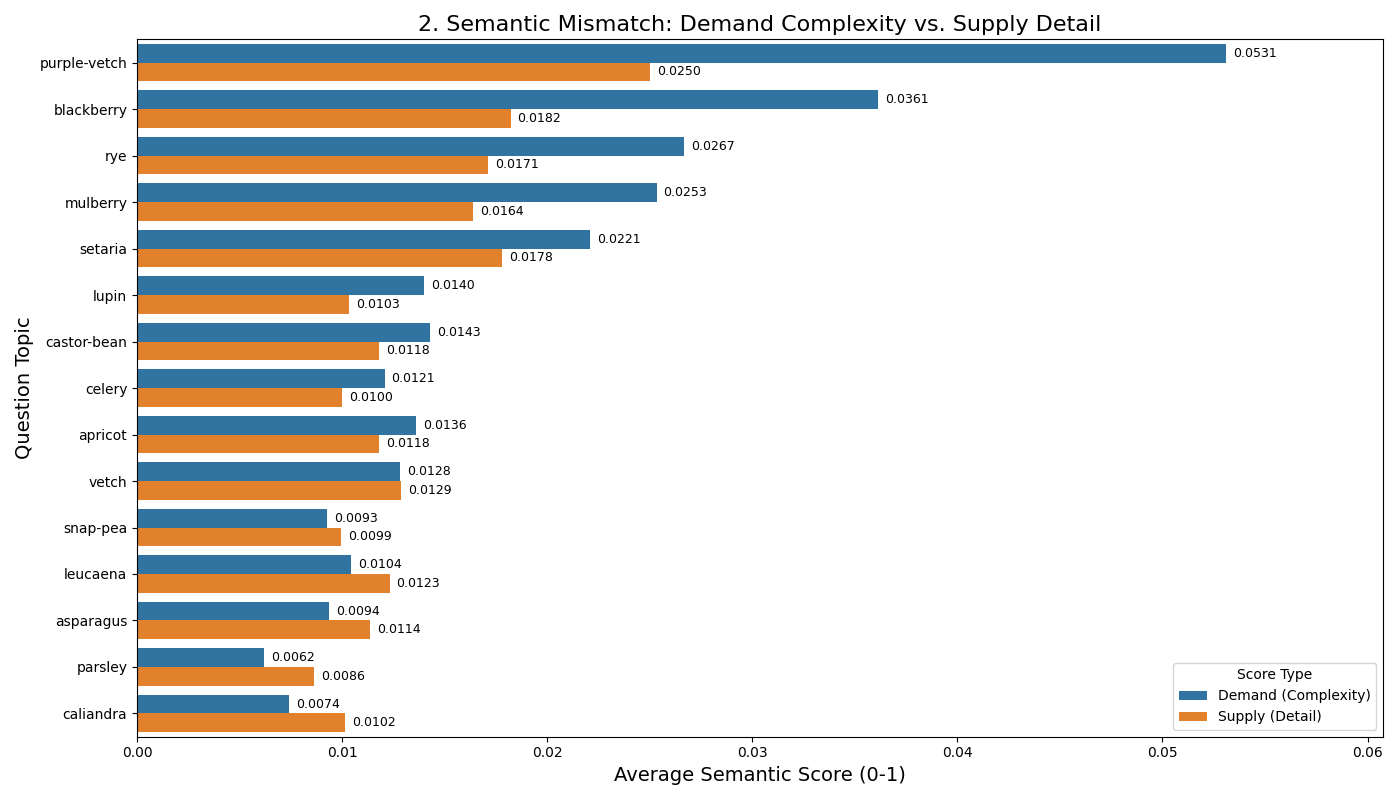

In [11]:
Image('2_supply_demand_mismatch_labeled.png')

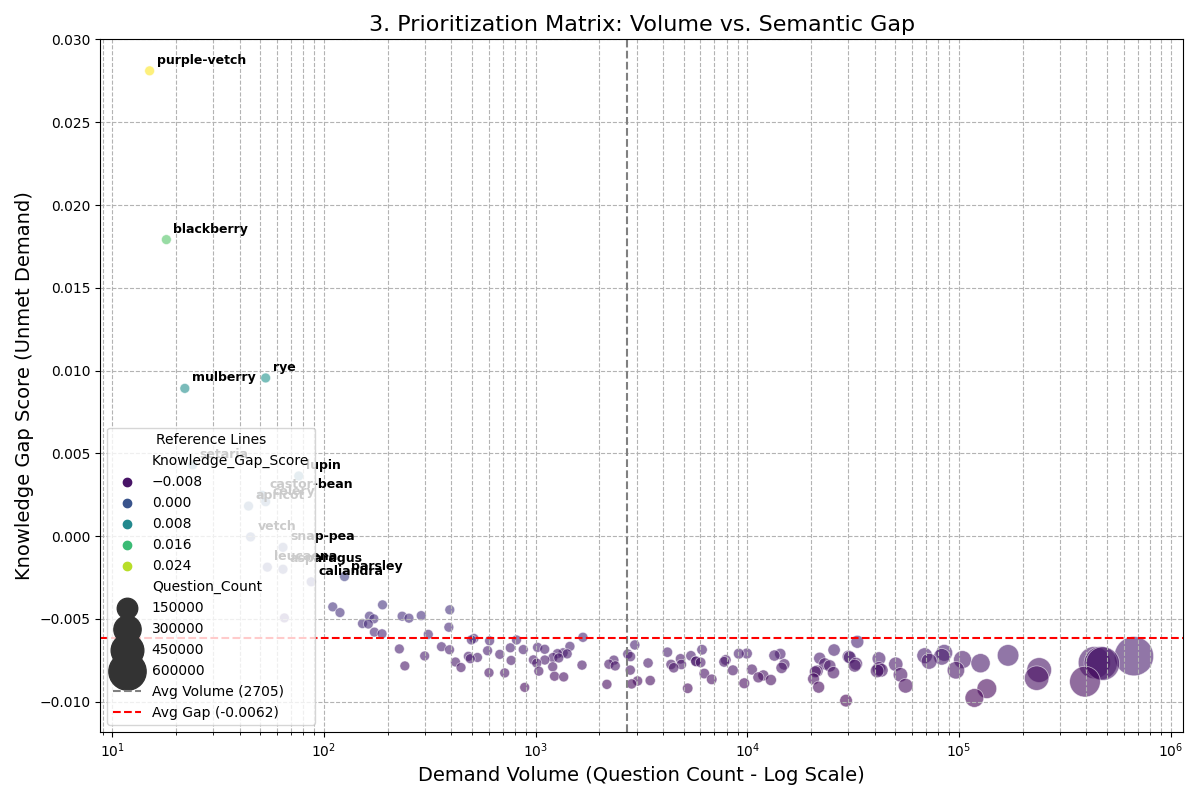

In [12]:
Image('3_priority_matrix_labeled_seaborn.png')